In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import easyocr

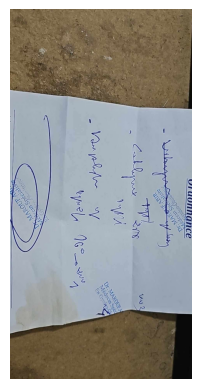

In [65]:
import matplotlib.pyplot as plt
import cv2

# Charger et convertir l'image en RGB
image = cv2.cvtColor(cv2.imread(r"C:\Users\jlassi\Desktop\EyeQ_app\image_filter_service\data\RealStar29.jpg"), cv2.COLOR_BGR2RGB)

# Remplace `implt(image)` par plt.imshow()
plt.imshow(image)
plt.axis('off')  # Supprime les axes pour un affichage plus propre
plt.show()


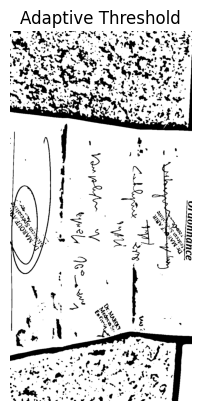

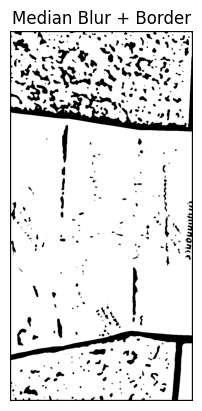

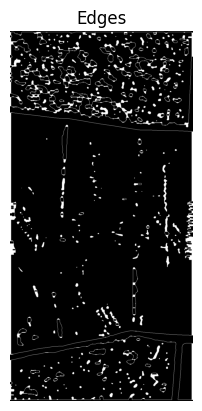

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_keep_ratio(img, width=800):
    """ Redimensionne l'image en gardant le ratio """
    h, w = img.shape[:2]
    ratio = width / w
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

def edgesDet(img, minVal, maxVal):
    """ Prétraitement + détection des contours avec Canny """
    img = cv2.cvtColor(resize_keep_ratio(img), cv2.COLOR_BGR2GRAY)

    # Appliquer un filtre bilatéral et un seuillage adaptatif
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)

    # Affichage
    plt.imshow(img, cmap='gray')
    plt.title("Adaptive Threshold")
    plt.axis('off')
    plt.show()

    # Flou médian
    img = cv2.medianBlur(img, 11)

    # Ajout d'une bordure noire
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Affichage
    plt.imshow(img, cmap='gray')
    plt.title("Median Blur + Border")
    plt.axis('off')
    plt.show()

    return cv2.Canny(img, minVal, maxVal)

# Charger l'image
#image = cv2.cvtColor(cv2.imread("/content/6fb4b493-ed73-41b5-be0c-3bbca201cb9b (1).png"), cv2.COLOR_BGR2RGB)

# Détection des bords
imageEdges = edgesDet(image, 200, 250)

# Fermer les gaps entre les bords
closedEdges = cv2.morphologyEx(imageEdges, cv2.MORPH_CLOSE, np.ones((5, 11)))

# Affichage
plt.imshow(closedEdges, cmap='gray')
plt.title("Edges")
plt.axis('off')
plt.show()


enhance quality


Image chargée avec succès.
closedEdges contient des contours.
Dimensions de closedEdges : (1642, 810)
Contours trouvés (4 points) : [[[   0  362]]

 [[   0 1435]]

 [[ 809 1350]]

 [[ 809  446]]]


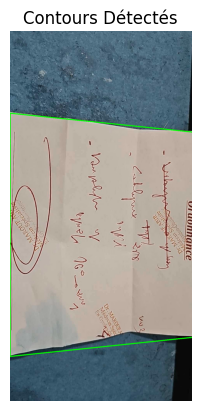

C:\Users\jlassi\AppData\Local\Temp\ipykernel_6324\1021321973.py:74: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=100, p=0.3),


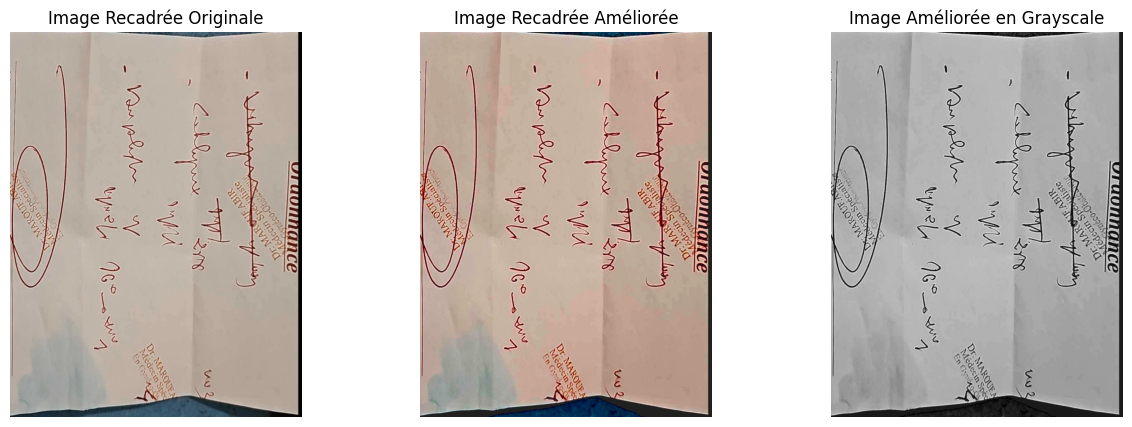

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

def resize_keep_ratio(img, width=800):
    """ Redimensionne l'image en gardant le ratio """
    if len(img.shape) == 3:
        h, w, c = img.shape
    else:
        h, w = img.shape
    ratio = width / w
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

def get_ratio(img, width=800):
    """ Calcule le ratio entre l'image originale et redimensionnée """
    return img.shape[1] / width

def findPageContours(closedEdges, img):
    """ Trouver un contour de page avec exactement 4 points """
    if len(closedEdges.shape) != 2:
        raise ValueError("closedEdges doit être une image 2D (binaire).")
    
    contours, _ = cv2.findContours(closedEdges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None

    for cnt in sorted(contours, key=cv2.contourArea, reverse=True):
        perimeter = cv2.arcLength(cnt, True)
        epsilon = 0.01 * perimeter
        while epsilon < 0.1 * perimeter:
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            if len(approx) == 4 and cv2.isContourConvex(approx):
                return approx
            epsilon += 0.01 * perimeter
    
    print("Aucun contour avec exactement 4 points n'a été trouvé.")
    return None

def perspImageTransform(img, sPoints):
    """ Transforme la perspective à partir des points sources vers les points cibles """
    height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
                 np.linalg.norm(sPoints[2] - sPoints[3]))
    width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
                 np.linalg.norm(sPoints[3] - sPoints[0]))

    tPoints = np.array([[0, 0], [0, height], [width, height], [width, 0]], dtype=np.float32)

    if sPoints.dtype != np.float32:
        sPoints = sPoints.astype(np.float32)

    M = cv2.getPerspectiveTransform(sPoints, tPoints)
    transformed_image = cv2.warpPerspective(img, M, (int(width), int(height)))
    return transformed_image

def implt(img, t='Image', grayscale=False):
    """ Affiche l'image avec un titre, avec option pour grayscale """
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(t)
    plt.axis('off')
    plt.show()

def improve_image(img):
    """ Améliore l'image avec Albumentations """
    transform = A.Compose([
        A.GaussianBlur(blur_limit=(1, 3), p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, p=0.7),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, val_shift_limit=50, p=0.6),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.6),
        A.ImageCompression(quality_lower=100, p=0.3),
    ])
    augmented = transform(image=img)
    return augmented['image']

# Vérification de l'image
if image is None:
    print("Erreur : Impossible de charger l'image !")
else:
    print("Image chargée avec succès.")

# Redimensionner l'image
resized_image = resize_keep_ratio(image)

# Vérifier `closedEdges`
if closedEdges is None or np.count_nonzero(closedEdges) == 0:
    print("Erreur : closedEdges est vide ou n'a pas de contours !")
else:
    print("closedEdges contient des contours.")

# Vérifier les dimensions de closedEdges
print("Dimensions de closedEdges :", closedEdges.shape)

# Trouver les contours de la page
if closedEdges is not None and len(closedEdges.shape) == 2:
    pageContour = findPageContours(closedEdges, resized_image)
else:
    print("Erreur : closedEdges n'est pas une image 2D valide.")
    pageContour = None

# Vérifier `pageContour`
if pageContour is None or len(pageContour) == 0:
    print("Erreur : Aucun contour trouvé !")
else:
    print("Contours trouvés (4 points) :", pageContour)

    # Afficher l'image avec les contours détectés (optionnel)
    contour_image = resized_image.copy()
    cv2.drawContours(contour_image, [pageContour], -1, (0, 255, 0), 3)
    implt(contour_image, t="Contours Détectés")

    # Extraire les 4 points du contour
    sPoints = pageContour.squeeze()

    # Appliquer la transformation de perspective pour recadrer
    cropped_image = perspImageTransform(resized_image, sPoints)

    # Appliquer l'amélioration à l'image recadrée
    improved_image = improve_image(cropped_image)

    # Convertir l'image améliorée en niveaux de gris
    grayscale_image = cv2.cvtColor(improved_image, cv2.COLOR_BGR2GRAY)

    # Afficher les images avant et après amélioration, plus la version grayscale
    plt.figure(figsize=(15, 5))

    # Image recadrée avant amélioration
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title('Image Recadrée Originale')
    plt.axis('off')

    # Image recadrée après amélioration (couleur)
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(improved_image, cv2.COLOR_BGR2RGB))
    plt.title('Image Recadrée Améliorée')
    plt.axis('off')

    # Image améliorée en niveaux de gris
    plt.subplot(1, 3, 3)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Image Améliorée en Grayscale')
    plt.axis('off')

    plt.show()